<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Discovering-DNA-motifs-using-convolutional-neural-networks" data-toc-modified-id="Discovering-DNA-motifs-using-convolutional-neural-networks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Discovering DNA motifs using convolutional neural networks</a></span></li><li><span><a href="#EWSR1-motif" data-toc-modified-id="EWSR1-motif-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EWSR1 motif</a></span></li><li><span><a href="#Generating-sequences" data-toc-modified-id="Generating-sequences-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generating sequences</a></span></li><li><span><a href="#Labeling-the-sequences" data-toc-modified-id="Labeling-the-sequences-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Labeling the sequences</a></span></li><li><span><a href="#Preparing-the-data-for-ingestion-into-a-neural-network" data-toc-modified-id="Preparing-the-data-for-ingestion-into-a-neural-network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Preparing the data for ingestion into a neural network</a></span></li><li><span><a href="#Building-a-convolution-neural-network" data-toc-modified-id="Building-a-convolution-neural-network-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Building a convolution neural network</a></span></li><li><span><a href="#Metrics-to-assess-bias-and-variance-during-training" data-toc-modified-id="Metrics-to-assess-bias-and-variance-during-training-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Metrics to assess bias and variance during training</a></span></li><li><span><a href="#Training-the-network" data-toc-modified-id="Training-the-network-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Training the network</a></span></li><li><span><a href="#Evaluating-the-network" data-toc-modified-id="Evaluating-the-network-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Evaluating the network</a></span></li><li><span><a href="#Interlude:-relaxing-the-problem-and-the-effect-of-increasing-mean-depth" data-toc-modified-id="Interlude:-relaxing-the-problem-and-the-effect-of-increasing-mean-depth-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Interlude: relaxing the problem and the effect of increasing mean depth</a></span></li><li><span><a href="#More-complex-neural-network" data-toc-modified-id="More-complex-neural-network-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>More complex neural network</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#To-Do" data-toc-modified-id="To-Do-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>To Do</a></span></li></ul></div>

## Discovering DNA motifs using convolutional neural networks

The goal is to train a convolutional neural network to predict whether a given input sequence contains a given motif. We will do this by generating synthetic training examples (sequences) that have been labeled according to whether they contain a given motif or not. The labeling will be a simulated per-base read-depth coverage observed at the center of the DNA sequence. The hope is that the trained network can be used to recover, somehow, the injected motif. 



## EWSR1 motif 

In order to facilitate comparison with the classification task we analyzed previously, we will start with the following motif from [JASPAR](http://jaspar.genereg.net/cgi-bin/jaspar_db.pl?ID=MA0149.1&rm=present&collection=CORE):
![title](http://jaspar.genereg.net/static/logos/MA0149.1.BIG.png)

In [1]:
import numpy as np
motif = np.array([[   0,   2, 104, 104,   1,   2, 103, 102,   0,   0,  99, 105,   0,   0, 100, 102,   5,   3],
                  [   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   4,   0,   0,   2,   3,   0,   0,   3],
                  [ 105, 103,   1,   1, 104, 102,   2,   3, 104, 103,   2,   0, 105, 103,   0,   2,  97,  97],
                  [   0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   2,   1,   3,   2]])


## Generating sequences

We wish to create a set of "positive" examples in which the motif is embedded. We can do this by drawing nucleotides at random with probabilities proportional to the frequency matrix, and then extending the sequence so generated upstream and downstream by drawing nucleotides at random with equal probability: 

In [2]:
sequence_length = 30
motif_plus_background = np.hstack([np.ones((4, (sequence_length-motif.shape[1])//2)), 
                                   motif,
                                   np.ones((4, (sequence_length-motif.shape[1])//2))])

number_positive_examples = 5000
number_negative_examples = 995000

positive_examples = \
np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                           size=number_positive_examples, 
                           p=motif_plus_background[:,position]/float(np.sum(motif_plus_background[:,position]))) 
          for position in range(sequence_length)]).transpose()

sequences_positive = []
for positive_example in positive_examples: 
    sequences_positive.append(''.join(positive_example))
    
sequences_positive[:5]

['AGAAAAGGAAGGAAGGAAGGAAGGACCTGT',
 'ATCAGTGGAAGGAAGGAAGGAAGGTCTCCC',
 'ATTTTAGGAAGGAAGGAAGGAAGGTATTGT',
 'TTCGCGGGAAGGAAGGAAGGAAGAAGTGGA',
 'CCAAAAGGAAGGAAGGAAGGAAGGCTGTTC']

Now let's produce a set of "negative" examples (i.e., examples not containing the motif) by sampling nucleotides with equal frequency, regardless of their position in the sequence: 

In [3]:
negative_examples = \
np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                           size=number_negative_examples, 
                           p=np.array([1,1,1,1])/4.0) 
          for position in range(sequence_length)]).transpose()

sequences_negative = []
for negative_example in negative_examples: 
    sequences_negative.append(''.join(negative_example))
sequences_negative[:5]

['CGCCCTCGGAGCAAAAACACCCCGTCATGA',
 'AGGAGCGCGTTTAGAGTCGAGAGTTGAACC',
 'AACTGCGTACGGGATGCTGGCTCATTTACC',
 'GAATGTAACTTGTCGGACTGGAGCCTGCTT',
 'CCCACTCATTTTGTACTAGCTACGACAACT']

## Labeling the sequences

We now wish to label these examples with a simulated read depth. 

Read depth $N$ can be interpreted as a noisy signal: the signal is assumed to be a number $N_s$ that is dependent upon the local DNA sequence and the noise comes from Poisson fluctuations about that signal: 

\begin{equation} 
P(N=k) = \frac{N_s^{k} e^{-N_s}}{k!} .
\end{equation} 

Suppose that there are just two values of the signal $N_s$: 

\begin{equation} 
N_s = 
\left\{ \begin{array}{ll}
\alpha & \mbox{motif not present}; \\
\alpha \beta & \mbox{motif present};
\end{array}
\right.
\end{equation} 




In [4]:
alpha = 100
beta = 0.1
def compute_noisy_signals(motif=True):
    number_examples = number_positive_examples if motif else number_negative_examples
    signals = np.ones(shape=number_examples, dtype=float)*alpha
    if motif: 
        signals *= beta
    # https://github.com/numpy/numpy/issues/7843 
    depths = np.random.poisson(lam=signals[:, np.newaxis], 
                               size=(len(signals), 1)) 
    return depths.flatten()

noisy_signals_positive = compute_noisy_signals(motif=True)
noisy_signals_negative = compute_noisy_signals(motif=False)

## Preparing the data for ingestion into a neural network



The data is currently highly imbalanced: examples from the negative class vastly outnumber those from the positive class:

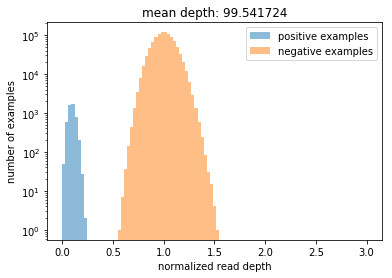

In [5]:
observed_mean_depth = np.mean(np.concatenate((noisy_signals_positive, noisy_signals_negative)))

import matplotlib.pyplot as plt
%matplotlib inline 

bins = np.linspace(0, 3, 100)
plt.hist(noisy_signals_positive/observed_mean_depth, bins, alpha=0.5, label='positive examples')
plt.hist(noisy_signals_negative/observed_mean_depth, bins, alpha=0.5, label='negative examples')
plt.legend(loc='upper right')
plt.ylabel('number of examples')
plt.xlabel('normalized read depth')
plt.yscale('log')
_ = plt.title('mean depth: ' + str(observed_mean_depth))

This imbalance is a problem because we will soon be maximizing the likelihood of getting ALL the data under a given model and the imbalance means that the likelihood will be largely determined by the ability of the model to predict the majority class, whereas we want the model to discrimminate between the classes.

One way to counteract the tendancy to fit data from the majority class at the expense of poorly fitting data from the minority class is to re-balance the classes: 

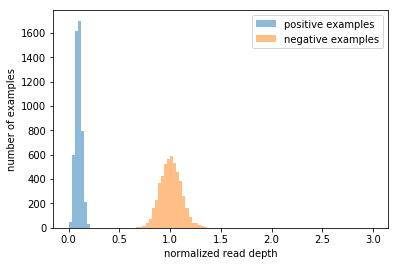

In [6]:
import pandas as pd
from collections import OrderedDict 

data_original = pd.DataFrame(OrderedDict([
    ('sequence', np.concatenate((sequences_positive, sequences_negative))),
    ('observed_depth', np.concatenate((noisy_signals_positive, noisy_signals_negative))),
    ('class', np.concatenate((np.ones_like(noisy_signals_positive, dtype=int), 
                              np.zeros_like(noisy_signals_negative, dtype=int)))),
    ('lambda', np.concatenate((alpha*beta*np.ones_like(noisy_signals_positive),
                               alpha*np.ones_like(noisy_signals_negative))))
]))

# add fake genomic positions
data_original['position'] = np.random.permutation(len(data_original))

def rebalance__two_classes(df):
    positive_class = df['observed_depth'] < 0.5*observed_mean_depth
    df_positive_balanced = df[positive_class]
    df_negative_balanced = df[~positive_class].sample(n=len(df_positive_balanced))

    plt.hist(df_positive_balanced['observed_depth']/observed_mean_depth, bins, alpha=0.5, label='positive examples')
    plt.hist(df_negative_balanced['observed_depth']/observed_mean_depth, bins, alpha=0.5, label='negative examples')
    plt.legend(loc='upper right')
    plt.ylabel('number of examples')
    _ = plt.xlabel('normalized read depth')

    return pd.concat([df_positive_balanced, df_negative_balanced])

data = rebalance__two_classes(data_original)

Next, split the data into train, dev and test sets. First, though, we must shuffle the data so that the distribution of positive and negative classes is the same in the three data sets (recall that the positive examples appeared at the head of the list of examples, and the negative examples at the tail). 

In [7]:
# shuffle data
data = data.sample(frac=1) 

# split data
test_dev_sets_size = min(1000, int(0.1*len(data)))
data_test = data[:test_dev_sets_size]
data_dev = data[test_dev_sets_size:2*test_dev_sets_size]
data_train = data[2*test_dev_sets_size:]

Since the sequences are categorical data, we must encode them as numbers before passing them into a function that maps them to read depths. We use "one-hot encoding", creating a tensor with dimensions `(number_examples, sequence_length, number_channels)` where `number_channels = 4`: 

In [8]:
from load_preprocess_data import _preprocess_conv1d
X_test, y_test = _preprocess_conv1d(data_test)
X_dev, y_dev = _preprocess_conv1d(data_dev)
X_train, y_train = _preprocess_conv1d(data_train)

## Building a convolution neural network 

Next, we set up a convolution neural network to map sequence to read depth: 

In [9]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout

# https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
K.clear_session()
baseline_model = Sequential()
baseline_model.add(Conv1D(filters=1, 
                 kernel_size=motif.shape[1], 
                 input_shape=(sequence_length, 4), 
                 use_bias=False,
                 padding='valid',
                 activation='relu'))

print('conv filters in first conv layer have dimension kernel_size X number_input_channels X number_output_channels')
print('shape of conv filter', baseline_model.layers[0].get_weights()[0].shape)
print('')

# INVERTED DROPOUT
# "Dropout" gets applied to the output of preceding layer (at training time only):
# https://keras.io/layers/core/#dropout
# weights are scaled by inverse of dropout rate (at training time only):
# see: line 2277 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
# also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
# also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
baseline_model.add(Dropout(rate=0.25)) 

baseline_model.add(Flatten())

# when "activation" is a string, keras attempts to "deserialize" it: 
# https://github.com/keras-team/keras/blob/8a73aec637a853f0fccb544dcb61dfe170db1277/keras/activations.py#L201
# https://github.com/keras-team/keras/blob/9e410e7839793d232276253a6a560153bcb6cce6/keras/utils/generic_utils.py#L157
baseline_model.add(Dense(units=1, activation='exponential'))

# when "loss" is a string, keras attempts to "deserialize" it: 
# https://github.com/keras-team/keras/blob/7bee9a18d83899ce6dfd50c4883afc678139f4ad/keras/losses.py#L133
# https://github.com/keras-team/keras/blob/7bee9a18d83899ce6dfd50c4883afc678139f4ad/keras/losses.py#L86
baseline_model.compile(optimizer='adam', loss='poisson') 

print('baseline_model.inputs', baseline_model.inputs)
print('baseline_model.outputs', baseline_model.outputs)
baseline_model.summary()

Using TensorFlow backend.


conv filters in first conv layer have dimension kernel_size X number_input_channels X number_output_channels
shape of conv filter (18, 4, 1)

baseline_model.inputs [<tf.Tensor 'conv1d_1_input:0' shape=(?, 30, 4) dtype=float32>]
baseline_model.outputs [<tf.Tensor 'dense_1/Exp:0' shape=(?, 1) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 13, 1)             72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 1)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 14        
Total params: 86
Trainable params: 86
Non-trainable params: 0
____________________________________

## Metrics to assess bias and variance during training

In [10]:
from keras.callbacks import Callback

# custom keras callback to record the losses in a consistent way
# (keras metrics may not compute train and dev losses consistently: 
# https://stackoverflow.com/questions/49359489/how-are-metrics-computed-in-keras)
class CustomHistory(Callback):
    # loss WITHOUT L1 or L2 regularization,
    # which is appropriate for assessing the extent to which the model suffers from bias and variance
    def loss(self, y_true, y_pred):
        return np.mean(y_pred - y_true * np.log(y_pred + 1e-10))

    # minimum achievable loss
    def maximum_likelihood_loss(self, y_true):
        return self.loss(y_true=y_true, y_pred=y_true) 

    # loss for a model that just predicts mean depth:
    def feature_independent_loss(self, y_true):
        return self.loss(y_true=y_true, y_pred=np.mean(y_true))

    def on_train_begin(self, logs={}):
        self.epochs = []
        self.train_losses = []
        self.dev_losses = []
        self.test_losses = []
        self.maximum_likelihood_losses = []
        self.feature_independent_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        # invoking "predict" guarantees that loss is computed without dropout 
        self.train_losses.append(
            self.loss(y_true=y_train, 
                      y_pred=self.model.predict(X_train, verbose=0)))
        self.dev_losses.append(
            self.loss(y_true=y_dev, 
                      y_pred=self.model.predict(X_dev, verbose=0)))        
        self.test_losses.append(
            self.loss(y_true=y_test, 
                      y_pred=self.model.predict(X_test, verbose=0)))        
        self.maximum_likelihood_losses.append(
            self.maximum_likelihood_loss(y_true=y_train))        
        self.feature_independent_losses.append(
            self.feature_independent_loss(y_true=y_train))       
        

## Training the network

In [11]:
baseline_custom_history = CustomHistory()
baseline_standard_history = baseline_model.fit(x=X_train, 
                             y=y_train, 
                             validation_data=(X_dev, y_dev),
                             epochs=int(50*(10000/(len(y_train)))),
                             verbose=0,
                             callbacks=[baseline_custom_history]) 

Side Note: Keras shuffles the training data at each epoch: [see here](https://keras.io/getting-started/faq/#is-the-data-shuffled-during-training).

## Evaluating the network 

Let's monitor the network's performance during the training process: 

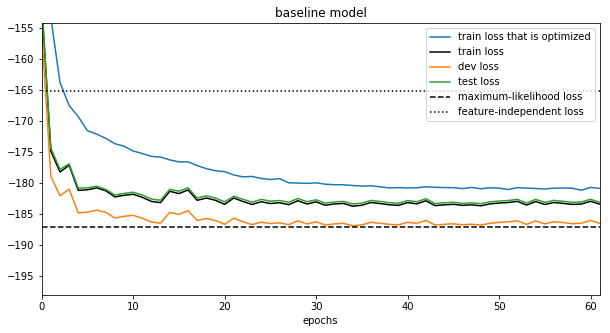

In [12]:
def plot_history(models):
    plt.figure(figsize=(10,5))    
    for name, standard_history, custom_history in models:
        plt.title(name)
        plt.plot(standard_history.epoch, 
                 standard_history.history['loss'], 
                 label='train loss that is optimized')
        plt.plot(custom_history.epochs, 
                 custom_history.train_losses, 
                 label='train loss', 
                 color='black')
        plt.plot(custom_history.epochs, 
                 custom_history.dev_losses, 
                 label='dev loss')
        plt.plot(custom_history.epochs, 
                 custom_history.test_losses, 
                 label='test loss')
        plt.plot(custom_history.epochs, 
                 custom_history.maximum_likelihood_losses, 
                 label='maximum-likelihood loss',
                 color='black', 
                 linestyle='--')
        plt.plot(custom_history.epochs, 
                 custom_history.feature_independent_losses,
                 label='feature-independent loss',
                 color='black', 
                 linestyle='dotted')
        plt.xlabel('epochs')
        plt.legend()
        plt.xlim([0, max(standard_history.epoch)])
        
        top = custom_history.feature_independent_losses[0]
        bottom = custom_history.maximum_likelihood_losses[0] 
        height = top - bottom
        ymin = bottom - 0.5*height
        ymax = top + 0.5*height
        plt.ylim([ymin, ymax])
            
plot_history([('baseline model', baseline_standard_history, baseline_custom_history)])

First note that that the dev and test losses are scattered about the training loss (solid black). This is because of sampling error/finite-size effects. The solid black curve is a pretty good estimator of the loss on an infinite population of examples because the training set size is large. In contrast, the dev and test curves, though also being estimators of the same quantity (because the three data sets are statistically identical), have much higher sampling errors because the sizes of those data sets are much smaller. You can convince yourself of this by increasing the sizes of the dev and test sets in this notebook, re-running it, and observing how the corresponding curves draw closer to each other and to the training curve. 

In the opposite limit---where the training set size is small and the dev and test sets are large---the dev and test curves again draw closer to one another, but move up from the training curve. This is the regime of over-fitting (also called high variance in the machine-learning community) where the training data set can be fit optimally because of its small size, but the learned model generalizes poorly to the unseen data (the dev and test sets). Again, this can be verified by altering the data set sizes and re-running the notebook.

Returning to the graph shown above, within the error that is made by the dev and test sets in estimating loss, the dev and test set losses are about the same as the training loss. This tells us that the model is not suffering from overfitting. 

Is the model under-fitting? The training loss (solid black) approaches its theoretical minimum value (dashed black), but how close to optimal is close enough? The answer to that question depends on what we are trying to achieve. 

Suppose the purpose of predicting read depth is to "correct" it. Concretely, letting $D$ represent depth, 
we wish to compute a corrected depth, 

\begin{equation} 
D_{corrected} = \frac{D_{observed}}{D_{predicted}},
\end{equation}

that lies outside some interval $I$ (centered on 1) less frequently than the corresponding uncorrected value, 

\begin{equation} 
D_{uncorrected} = \frac{D_{observed}}{\langle D_{observed} \rangle}.
\end{equation} 

One way to quantify this effect is: 

\begin{equation} 
\mbox{performance metric} = \frac{P\left[ D_{corrected} \in I \right]}
{P\left[ D_{uncorrected} \in I \right]}.
\end{equation}

Why might this performance metric be useful? Because values greater than unity might correspond to a reduction in the false-positive structural variant calls (deletions and duplications) produced by algorithms such as CNVnator as a result of feeding them corrected depths instead of uncorrected depths.

Let's compare corrected and uncorrected depths as a function of example ID (which you can think of as a genomic coordinate): 

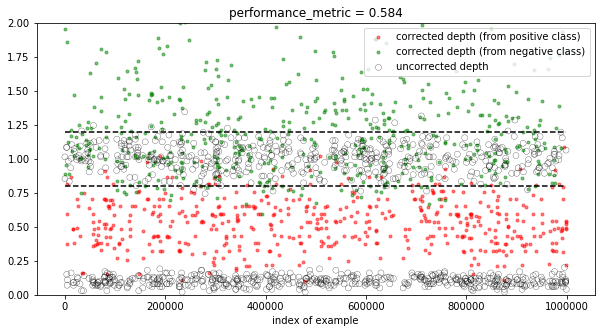

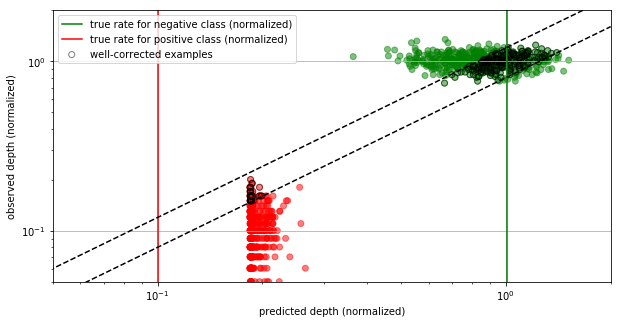

In [13]:
normalized_lower_depth_threshold, normalized_upper_depth_threshold = 0.8, 1.2

def performance_metric(df):
    cond_lower = df['corrected_depth'].values > normalized_lower_depth_threshold
    cond_upper = df['corrected_depth'].values < normalized_upper_depth_threshold
    prob_corrected = np.sum(cond_lower & cond_upper)/float(len(df))
    cond_lower = df['observed_depth'].values > normalized_lower_depth_threshold*observed_mean_depth
    cond_upper = df['observed_depth'].values < normalized_upper_depth_threshold*observed_mean_depth
    prob_observed = np.sum(cond_lower & cond_upper)/float(len(df))
    return prob_corrected/prob_observed

def colors__two_classes(df): 
    colors = []
    for class_membership in df['class']: 
        colors.append('red' if class_membership else 'green')
    return colors
    
def correct(df, model): 
    df = df.sample(n=1000)
    X, _ = _preprocess_conv1d(df)
    pd.options.mode.chained_assignment = None  # default='warn'
    df['predicted_depth'] = model.predict(X, verbose=0).squeeze()
    df['corrected_depth'] = df['observed_depth']/df['predicted_depth']
    return df
    
def evaluate__two_classes(df, model):
    df = correct(df, model)
    
    figsize=(10,5)
    normalized_max_depth = 2

    df_well_corrected = df[
        (df['corrected_depth'] > normalized_lower_depth_threshold) 
        &
        (df['corrected_depth'] < normalized_upper_depth_threshold)         
    ]

    plt.figure(figsize=figsize)
    plt.scatter(df[df['class'] == 1]['position'], 
                df[df['class'] == 1]['corrected_depth'].values, 
                marker='.',
                label='corrected depth (from positive class)',
                c='red',
                alpha=0.5)
    plt.scatter(df[df['class'] == 0]['position'], 
                df[df['class'] == 0]['corrected_depth'].values, 
                marker='.',
                label='corrected depth (from negative class)',
                c='green',
                alpha=0.5)
    plt.scatter(df['position'], 
                df['observed_depth'].values/observed_mean_depth,
                marker='o', facecolors='none', edgecolors='black', linewidth=0.25,
                label='uncorrected depth')
    plt.plot([0, max(df['position'])], [normalized_lower_depth_threshold, normalized_lower_depth_threshold], '--k')
    plt.plot([0, max(df['position'])], [normalized_upper_depth_threshold, normalized_upper_depth_threshold], '--k')
    plt.xlabel('index of example')
    _ = plt.legend(loc='upper right')
    plt.ylim([0, normalized_max_depth])
    plt.title('performance_metric = {:.3f}'.format(performance_metric(df)))

    plt.figure(figsize=figsize)    
    plt.scatter(df['predicted_depth']/observed_mean_depth, 
                df['observed_depth']/observed_mean_depth, 
                label=None,
                c=colors__two_classes(df),
                alpha=0.5)
    plt.scatter(df_well_corrected['predicted_depth']/observed_mean_depth, 
                df_well_corrected['observed_depth']/observed_mean_depth, 
                label='well-corrected examples',
                marker='o', facecolors='none', edgecolors='k',
                alpha=0.5)
    plt.xlabel('predicted depth (normalized)')
    plt.ylabel('observed depth (normalized)')
    plt.plot([alpha/observed_mean_depth, alpha/observed_mean_depth], 
             [0, normalized_max_depth], 
             'green', label='true rate for negative class (normalized)')
    plt.plot([alpha*beta/observed_mean_depth, 
              alpha*beta/observed_mean_depth], 
             [0, normalized_max_depth], 
             'red', label='true rate for positive class (normalized)')
    plt.plot([0, normalized_max_depth], 
             [0, (normalized_upper_depth_threshold)*normalized_max_depth], 
             '--k')
    plt.plot([0, normalized_max_depth], 
             [0, (normalized_lower_depth_threshold)*normalized_max_depth], 
             '--k')
    plt.legend(loc='upper left')
    plt.grid()
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([0.5*beta, normalized_max_depth])
    plt.xlim([0.5*beta, normalized_max_depth])

# data_original_shuffled = data_original.sample(frac=1)
evaluate__two_classes(data_dev, baseline_model)

The top graph shows that the algorithm has corrected the positive-class depths upwards, which is part of what we hoped to achieve. 

To improve the performance metric, we need to make more of the corrected depths sit inside the interval indicated by the dashed horizontal lines (top graph; interval chosen arbitrarily). The second graph quantifies how close the observed and predicted depths must be to one another to achieve this goal: examples need to lie in the interval indicated by the diagonal dashed lines. 

Clearly there are two things getting in the way of achieving this goal: 
* there is unwanted variance and bias in the predicted depths, which ideally should be tightly clustered along the red and green vertical lines (bottom graph) because predicted depth is really just the rate parameter in a Poisson distribution (the red and green lines represent the known truth for those parameters). In other words, for our use case, the model is underfitting the data. This is particularly evident from the fact that predicted depths seem to have a lower bound close to 0.2 (in normalized units). 
* there is unwanted variance in the observed depths, resulting from Poisson noise.  

We would like to attenuate both sources of variance, and remove that bias in predicted depth. 

In the next section, we will consider a relaxed version of our model where the variance and bias in the predictions are practically non-existent, allowing us to more cleanly study the effect of mitigating variance in observations. 


## Interlude: relaxing the problem and the effect of increasing mean depth

In the previous notebook in this series we successfully created a many-to-one mapping from DNA sequences to class labels. Can we create a model from an inherently one-to-many mapping such as that from class label to read depth? In this section, we will find that we can, and along the way we will show how to reduce the variance in observed depths, which is one of the things that is preventing us from adequately correcting read depth. 



First, create a model that maps class label into read depth: 

In [14]:
K.clear_session()
model_toy = Sequential()
model_toy.add(Dense(units=1, activation='exponential', input_shape=(1,), use_bias=True))
model_toy.compile(optimizer='adam', loss='poisson') 
model_toy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Next, write a function that generates synthetic data given arbitrary values of two rate parameters, whose effect on the ability to correct depth we will examine later: 

In [15]:
def generate_data_toy(lambda_low, lambda_high): 
    X_low = np.ones(shape=number_positive_examples, dtype=int) 
    y_low = np.random.poisson(lam=lambda_low, size=number_positive_examples)  
    X_high = np.zeros(shape=number_positive_examples, dtype=int)
    y_high = np.random.poisson(lam=lambda_high, size=number_positive_examples)  
    return pd.DataFrame(OrderedDict([
        ('observed_depth', np.concatenate((y_low, y_high))),
        ('class', np.concatenate((X_low, X_high))),
        ('lambda', np.concatenate((lambda_low*np.ones_like(y_low), 
                                   lambda_high*np.ones_like(y_high)))),
        ('position', np.random.permutation(2*number_positive_examples))
    ])).sample(frac=1)

Finally, some code to fit the model to the generated data and evaluate the fit, as we did for the convolution model earlier in the notebook: 

In [16]:
def evaluate_toy(df, model, lambda_low, lambda_high): 
    df = df.sample(n=1000)
    
    df['predicted_depth'] = model.predict(df['class'], verbose=0).squeeze()
    df['corrected_depth'] = df['observed_depth']/df['predicted_depth']

    df_positive = df[df['class'] == 1]
    df_negative = df[df['class'] == 0]

    normalized_max_depth = 2 
    
    figsize=(10,5)
    plt.figure(figsize=figsize)
    plt.scatter(df_positive['position'], 
                df_positive['corrected_depth'].values, 
                marker='.',
                label='corrected depth (from positive class)',
                c='red',
                alpha=0.5)
    plt.scatter(df_negative['position'], 
                df_negative['corrected_depth'].values, 
                marker='.',
                label='corrected depth (from negative class)',
                c='green',
                alpha=0.5)
    plt.scatter(df['position'], 
                df['observed_depth'].values/np.mean(df_negative['observed_depth']),
                marker='o', facecolors='none', edgecolors='black', linewidth=0.25,
                label='uncorrected depth')
    plt.legend()
    plt.xlabel('genomic coordinate')
    plt.plot([0, max(df['position'])], [normalized_lower_depth_threshold, normalized_lower_depth_threshold], '--k')
    plt.plot([0, max(df['position'])], [normalized_upper_depth_threshold, normalized_upper_depth_threshold], '--k')
    plt.ylim([0, normalized_max_depth])

        
    plt.figure(figsize=figsize)
    plt.scatter(df_positive['predicted_depth'], df_positive['observed_depth'], color='red')
    plt.scatter(df_negative['predicted_depth'], df_negative['observed_depth'], color='green')
    plt.xlabel('predicted depth')
    plt.ylabel('observed depth')
    _ = plt.plot([lambda_low, lambda_low], [0, lambda_high], 'red', label='true rate in positive class')
    _ = plt.plot([lambda_high, lambda_high], [0, lambda_high], 'green', label='true rate in negative class')
    _ = plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.plot([0, lambda_high], 
             [0, normalized_lower_depth_threshold*lambda_high], 
             '--k')
    plt.plot([0, lambda_high], 
             [0, normalized_upper_depth_threshold*lambda_high], 
             '--k')
    plt.ylim([0.5*lambda_low, 2*lambda_high])
    plt.xlim([0.5*lambda_low, 2*lambda_high])
    
def evaluate_toy__wrapper(lambda_low=10.0): 
    lambda_high = 10*lambda_low

    data_toy = generate_data_toy(lambda_low, lambda_high)

    model_toy.fit(x=data_toy['class'], 
                  y=data_toy['observed_depth'],
                  epochs=int(25*(10000/(len(data_toy)))),
                  verbose=0) 

    evaluate_toy(data_toy, model_toy, lambda_low, lambda_high)



Now, let's examine the quality of the correction:

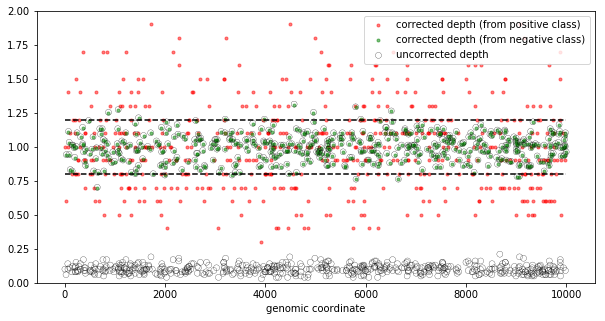

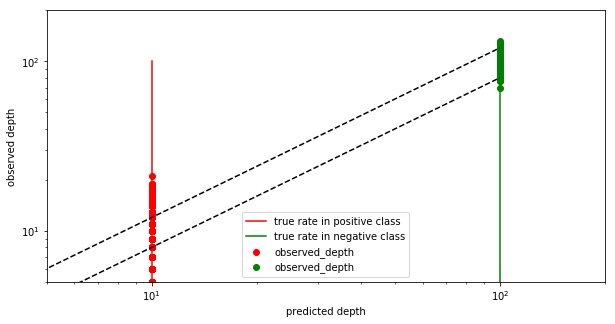

In [17]:
evaluate_toy__wrapper(lambda_low=10)

Notice that the model predicts the rate parameters perfectly in each case! Consequently, the only reason why some examples are poorly corrected is because of Poisson noise in the observations. 

Poisson noise can be reduced by increasing the mean depth, as we show in the following two plots (in each case the larger rate parameter is 10 times the smaller rate parameter): 

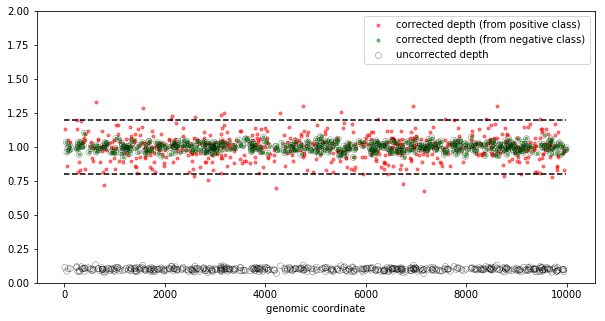

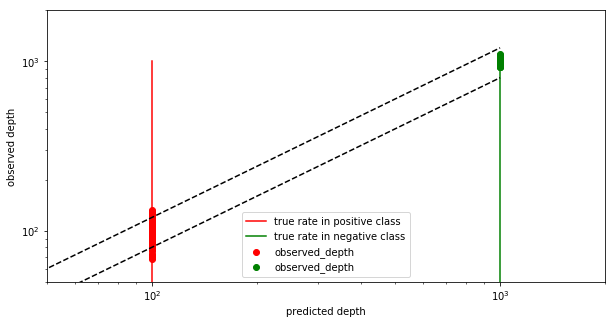

In [18]:
evaluate_toy__wrapper(lambda_low=100)

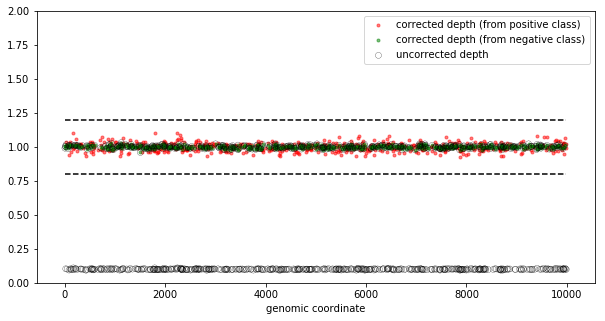

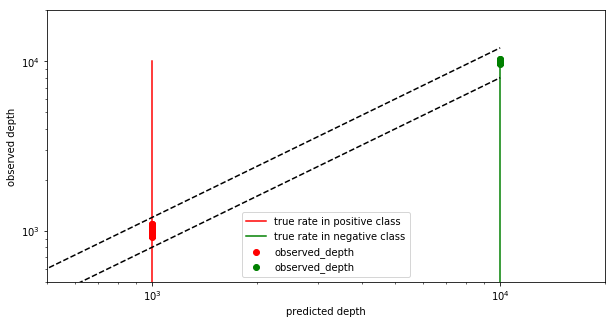

In [19]:
evaluate_toy__wrapper(lambda_low=1000)

## More complex neural network

Having discovered how to correct variance in observations, let us now tackle how to reduce variance and bias in the predictions. 

Here is a more complicated model applied to the original data set (where the model input is again sequence, not class label): 

In [20]:
K.clear_session()
model_1 = Sequential()
model_1.add(Conv1D(filters=100, 
                         kernel_size=motif.shape[1], 
                         input_shape=(sequence_length, 4), 
                         use_bias=False,
                         padding='valid',
                         activation='relu'))
model_1.add(Conv1D(filters=100, 
                         kernel_size=10, 
                         use_bias=False,
                         padding='valid',
                         activation='relu'))
model_1.add(Dropout(rate=0.5)) 
model_1.add(Flatten())
model_1.add(Dense(units=1, activation='exponential'))
model_1.compile(optimizer='adam', loss='poisson') 
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 13, 100)           7200      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 100)            100000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 100)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 107,601
Trainable params: 107,601
Non-trainable params: 0
_________________________________________________________________


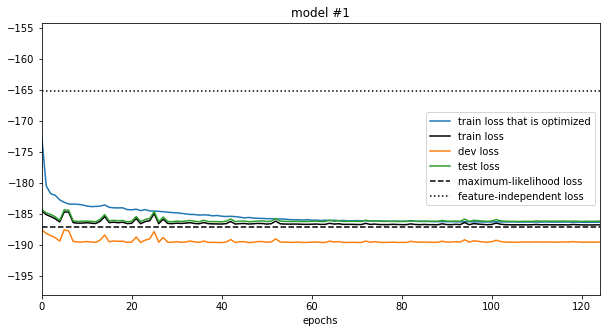

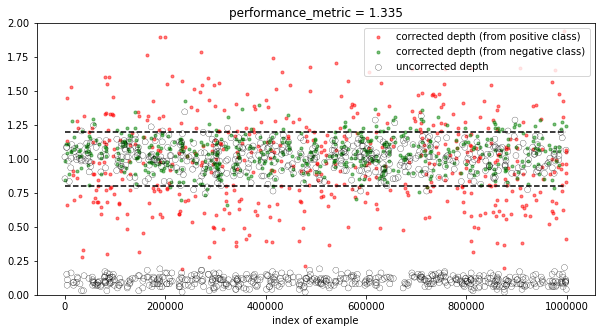

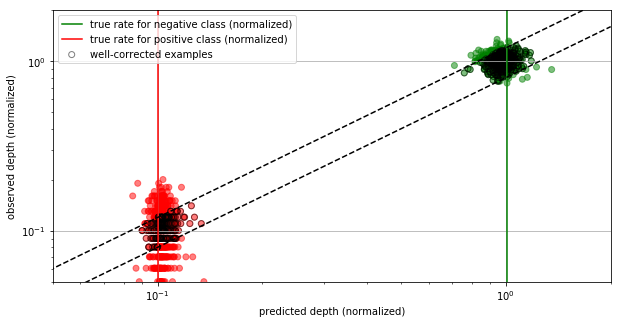

In [21]:
def train_evaluate(model, name, verbose=0):     
    custom_history = CustomHistory()
    standard_history = model.fit(x=X_train, 
                                 y=y_train, 
                                 validation_data=(X_dev, y_dev),
                                 epochs=int(100*(10000/(len(y_train)))),
                                 verbose=verbose,
                                 callbacks=[custom_history]) 
    plot_history([(name, standard_history, custom_history)])
    evaluate__two_classes(data_dev, model)

train_evaluate(model_1, 'model #1')

Great! We seem to have reduced variance in predicted depth and bias in predicted depth so that more examples are now well-corrected. 

Additionally, let's reduce the variance in observations by increasing the mean read depth: 

In [22]:
def update(df):   
    cond = df['class'] == 0
    df.loc[cond, 'observed_depth'] = np.random.poisson(lam=alpha, size=np.sum(cond))  
    df.loc[cond, 'lambda'] = alpha

    cond = df['class'] == 1
    df.loc[cond, 'observed_depth'] = np.random.poisson(lam=alpha*beta, size=np.sum(cond))  
    df.loc[cond, 'lambda'] = alpha*beta  

In [23]:
alpha = 1000

update(data_train)
update(data_dev)
update(data_test)

observed_mean_depth = np.mean(data_train[data_train['class'] == 0]['observed_depth'])

X_test, y_test = _preprocess_conv1d(data_test)
X_dev, y_dev = _preprocess_conv1d(data_dev)
X_train, y_train = _preprocess_conv1d(data_train)

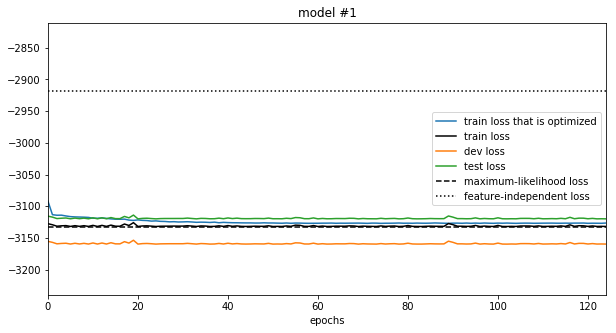

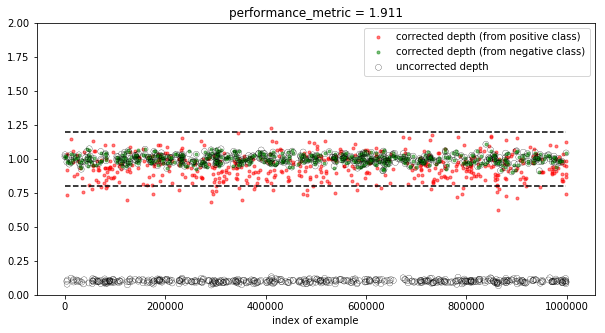

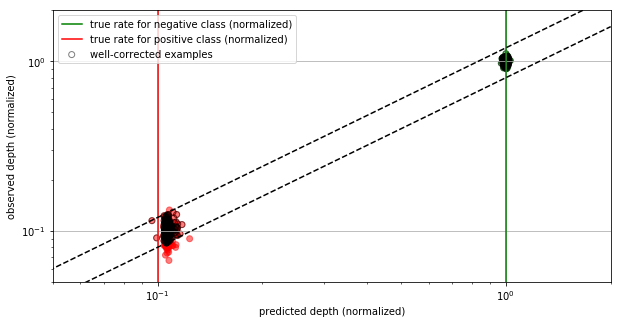

In [24]:
train_evaluate(model_1, 'model #1')

## Conclusion

Wow! We've corrected practically all of our examples, in a generalizable fashion, to an adequate degree by using a model with "only" 100K parameters, a data set consisting of only 10K examples, and a mean depth of "only" 1000X, which can be generated in practice by pooling read depths. 

## To Do

* Interrogate the learned convolution filters 
* Some positive class rates may be much closer to the negative class rates than we considered here (we assumed that the positive class rate is 10 times smaller). Can the approach adequately correct when the positive class rate is larger, e.g. only 2 times smaller than the negative class rate? 
* Apply this "pipeline" to real data by choosing, as positive examples, sequence intervals harboring the CCCGCC motif, which is known to reduce read depth: [Ekblom et al 2014](https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-15-467) and [Van den Hoecke et al 2016](https://www.nature.com/articles/srep26314). Also apply to positive-class examples harboring AT repeats, which have also been shown to affect read depth: [Smith et al 2015](https://peerj.com/articles/836/) and [Ross et al 2013](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2013-14-5-r51#Sec2).  
